# Finishing the encoder

__Contents:__

- <a href="#raw2feat">Create features from raw stimulus</a>
- <a href="#algorun">Initialize model and execute algorithm</a>
- <a href="#eval">Evaluate performance</a>
- <a href="#tasks">List of major tasks</a>

___

To the end of putting all the pieces together to get a fully-functional learning machine, let's load up the functions we prepared in other lessons.

In [1]:

import scripts.FilterBank as fb
import scripts.AlgoIntro as ai
import scripts.AlgoSparseReg as asr


The basic workflow of the final procedure is as follows:

    Load raw stimulus --> Generate and save visual features --> Fit sparse linear model.

We shall take this one piece at a time. After going through a simple and fast prototypical implementation of this encoder, we will put forward a series of exercises that constitute the bulk of the work to be done here.

<a id="raw2feat"></a>
## Create features from raw stimulus



In [2]:
import numpy as np
import math

# Import the vim-2 data from the Python binary format we saved earlier.
# Assumptions: that the data is saved in the vim-2 directory,
# already of 96x96 size, with dtype of np.float32.

PIX_W = 96
PIX_H = 96
dtype=np.float32

# Read the raw training data.
shape=(PIX_W,PIX_H,3,108000) # (downsized px, downsized px, rgd channels, time steps)
# Index for temporal down-sampling. Alternatives: do after the feature-building and aggregate.
idx_ds = np.arange(15//2, 108000+1, 15) # need length 7200.
fname = "data/vim-2/X_tr.dat"
with open(fname, mode="br") as fbin:
    print("Reading...", end=" ")
    raw_tr = np.fromfile(file=fbin,dtype=dtype).reshape(shape)[:,:,:,idx_ds] # temporally down-sampled.
    print("OK.")

# Check a few frames.
#num_frames = raw_tr.shape[3]
#frames_to_play = 5
#for t in range(frames_to_play):
#    plt.imshow(raw_tr[:,:,:,t])
#    plt.show()


# Read the raw testing data.
shape=(PIX_W,PIX_H,3,8100) # (downsized px, downsized px, rgd channels, time steps)
# Index for temporal down-sampling. Alternatives: do after the feature-building and aggregate.
idx_ds = np.arange(15//2, 8100+1, 15) # need length 540.
fname = "data/vim-2/X_te.dat"
with open(fname, mode="br") as fbin:
    print("Reading...", end=" ")
    raw_te = np.fromfile(file=fbin, dtype=dtype).reshape(shape)[:,:,:,idx_ds] # temporally down-sampled.
    print("OK.")

# Check a few frames.
#num_frames = raw_tr.shape[3]
#frames_to_play = 5
#for t in range(frames_to_play):
#    plt.imshow(raw_tr[:,:,:,t])
#    plt.show()


Reading... OK.
Reading... OK.


In [3]:

# Set up the parameters that specify the first filter bank.
myparas = {"freqs": 32/max(PIX_W,PIX_H),
           "dir": math.pi/2,
           "amp": 0.1,
           "sdev": max(PIX_W,PIX_H)/20,
           "phase": 0}
mygrid_h = 3
mygrid_w = 3

print("Getting features (tr)...", end=" ")
X_tr = fb.G2_getfeatures(ims=raw_tr,
                         fil_paras=myparas,
                         gridshape=(mygrid_h,mygrid_w),
                         mode="reflect", cval=0)
print("OK.")

print("Getting features (te)...", end=" ")
X_te = fb.G2_getfeatures(ims=raw_te,
                         fil_paras=myparas,
                         gridshape=(mygrid_h,mygrid_w),
                         mode="reflect", cval=0)
print("OK.")


Getting features (tr)... OK.
Getting features (te)... OK.


In [4]:
print("Shape of the produced features:")
print("tr:", X_tr.shape)
print("te:", X_te.shape)

Shape of the produced features:
tr: (7200, 9)
te: (540, 9)


The above parameters only give us a very limited number of features. As a simple example, let's prepare another set of features determined by a qualitatively distinct collection of filters, and concatenate these.

In [5]:
# Set up the parameters that specify the second filter bank.
myparas = {"freqs": 32/max(PIX_W,PIX_H),
           "dir": 0,
           "amp": 0.1,
           "sdev": max(PIX_W,PIX_H)/20,
           "phase": 0}
mygrid_h = 9
mygrid_w = 9

print("Getting features (tr)...", end=" ")
tmp_X = fb.G2_getfeatures(ims=raw_tr,
                         fil_paras=myparas,
                         gridshape=(mygrid_h,mygrid_w),
                         mode="reflect", cval=0)
print("OK.")
X_tr = np.concatenate((X_tr, tmp_X), axis=1) # concatenate!

print("Getting features (te)...", end=" ")
tmp_X = fb.G2_getfeatures(ims=raw_te,
                         fil_paras=myparas,
                         gridshape=(mygrid_h,mygrid_w),
                         mode="reflect", cval=0)
print("OK.")
X_te = np.concatenate((X_te, tmp_X), axis=1) # concatenate!

print("Shape of the produced features:")
print("tr:", X_tr.shape)
print("te:", X_te.shape)

Getting features (tr)... OK.
Getting features (te)... OK.
Shape of the produced features:
tr: (7200, 90)
te: (540, 90)


Note that the concatenation just adds columns of feature vectors; the number of samples (and thus rows in the array) is constant.

Again following Nishimoto et al. (2011), let us compute the so-called Z-score of the feature values, in order to center the mean and standardize the scale. In addition, a hard truncation of outliers is carried out. This is done separately for training and testing data, to ensure the learner does not gain unfair oracle information.

In [6]:

X_tr = X_tr - np.mean(X_tr, axis=0)
X_tr = X_tr / np.std(X_tr, axis=0)
print("Mean =", np.mean(X_tr, axis=0), "StdDev =", np.std(X_tr, axis=0))

X_te = X_te - np.mean(X_te, axis=0)
X_te = X_te / np.std(X_te, axis=0)
print("Mean =", np.mean(X_te, axis=0), "StdDev =", np.std(X_te, axis=0))

for j in range(X_tr.shape[1]):
    stdval = np.std(X_tr[:,j])
    X_tr[:,j] = np.clip(X_tr[:,j], a_min=(-stdval), a_max=stdval)
    stdval = np.std(X_te[:,j])
    X_te[:,j] = np.clip(X_te[:,j], a_min=(-stdval), a_max=stdval)


Mean = [  2.58357159e-06  -8.92488515e-07   5.57957435e-07  -4.96258338e-07
  -1.69749057e-06   9.48549996e-07  -2.33410134e-07  -1.02121794e-06
   1.77970367e-06  -1.18050307e-08   8.10722497e-07  -1.43411262e-06
   3.32246231e-07   5.24578809e-07   1.41411192e-06   6.26593817e-08
  -1.32421647e-07  -1.81612037e-07   9.25486290e-07   1.96074453e-07
   1.67777966e-06   5.08626314e-08   1.45783030e-08   4.33185022e-07
   4.19616697e-07   1.14723207e-06   1.72787239e-07   3.96553020e-07
   1.54698887e-06  -9.43500140e-07   3.42387295e-07  -1.26283203e-06
   6.70444649e-07  -7.34544471e-07   1.22170479e-06   1.41645467e-06
  -6.07909442e-07   2.06748655e-06   1.42157910e-06  -1.08564893e-06
   1.37013694e-06  -1.70287166e-07  -2.96019834e-07  -5.49770078e-08
  -4.36430184e-07  -8.49920866e-07   6.96124289e-07  -2.97485116e-07
  -1.17873981e-06  -1.08703972e-07  -3.01607770e-07  -1.50195433e-07
  -3.78158347e-07   1.52405761e-07   9.67168177e-08   8.73878605e-07
  -4.91572756e-08   3.38041

Assuming everything worked up to this point, write the features to disk, and at the same time create a corresponding "data info" object, also written to disk.

In [7]:
import support.classes as classes

# Make a data_info file for this data, and save as data/encoder/info.dat.
dinfo = classes.DataInfo()
dinfo.mname = "Encoder"

fname = "data/encoder/X_tr.dat"
dtype = raw_tr.dtype
shape = raw_tr.shape
with open(fname, mode="bw") as fbin:
    X_tr.tofile(fbin)
    print("Saved to file.")
dinfo.X_tr["shape"] = X_tr.shape
dinfo.X_tr["path"] = "data/encoder/X_tr.dat"
dinfo.X_tr["dtype"] = X_tr.dtype
    
fname = "data/encoder/X_te.dat"
dtype = raw_te.dtype
shape = raw_te.shape
with open(fname, mode="bw") as fbin:
    X_te.tofile(fbin)
    print("Saved to file.")
dinfo.X_te["shape"] = X_te.shape
dinfo.X_te["path"] = "data/encoder/X_te.dat"
dinfo.X_te["dtype"] = X_te.dtype

Saved to file.
Saved to file.


In [8]:
import support.classes as classes

# Make a data_info file for this data, and save as data/encoder/info.dat.
dinfo = classes.DataInfo()
dinfo.mname = "Encoder"

fname = "data/encoder/X_tr.dat"
dtype = raw_tr.dtype
shape = raw_tr.shape
with open(fname, mode="bw") as fbin:
    X_tr.tofile(fbin)
    print("Saved to file.")
dinfo.X_tr["shape"] = X_tr.shape
dinfo.X_tr["path"] = "data/encoder/X_tr.dat"
dinfo.X_tr["dtype"] = X_tr.dtype

fname = "data/encoder/X_te.dat"
dtype = raw_te.dtype
shape = raw_te.shape
with open(fname, mode="bw") as fbin:
    X_te.tofile(fbin)
    print("Saved to file.")
dinfo.X_te["shape"] = X_te.shape
dinfo.X_te["path"] = "data/encoder/X_te.dat"
dinfo.X_te["dtype"] = X_te.dtype

# Clear the raw data from memory.
del [raw_te, raw_tr]


Saved to file.
Saved to file.


As for the responses (and the index of voxels free of missing values), just move or copy them over to our `encoder` directory,

```
$ mv data/vim-2/y_tr.dat data/vim-2/y_te.dat ./data/encoder/
$ mv data/vim-2/cleanidx_tr.dat data/vim-2/cleanidx_te.dat ./data/encoder/

```

and then similarly populate the remaining attributes of `dinfo` and write to disk, as follows.

In [9]:

import pickle

fname = "data/encoder/y_tr.dat"
dinfo.y_tr["shape"] = (73728, 7200)
dinfo.y_tr["path"] = "data/encoder/y_tr.dat"
dinfo.y_tr["dtype"] = np.float32

fname = "data/encoder/y_te.dat"
dinfo.y_te["shape"] = (73728, 540)
dinfo.y_te["path"] = "data/encoder/y_te.dat"
dinfo.y_te["dtype"] = np.float32

dinfo.misc = {"voxidx": None} # to be filled in later.

with open("data/encoder/info.dat", mode="bw") as fbin:
    pickle.dump(dinfo, fbin)
    print("Saved to file.")


Saved to file.


<a id="algorun"></a>
## Initialize model and execute algorithm

Assuming the above has all been run once, then we can feel free to restart the kernel and run from here.

We shall run the `Algo_LASSO_CD` routine implemented in a previous lesson here, over a grid of $\lambda$ parameters controlling the impact of the $\ell_{1}$ norm constraint. As for performance metrics, citing the Nishimoto et al. (2011) work, from which this data set was born:

> *"Prediction accuracy was defined as the correlation between predicted and observed BOLD signals. The averaged accuracy across subjects and voxels in early visual areas (V1, V2, V3, V3A, and V3B) was 0.24, 0.39, and 0.40 for the static, nondirectional, and directional encoding models, respectively."*

Every element of our implementation is less sophisticated than theirs, from the filter bank used to create inputs, to the learning procedure used to set parameter values, and thus this performance should be considered an upper bound for the performance we can achieve in our pedagogical exercise here. In particular, since we are only using two-dimensional Gabor filters, our encoding model corresponds to a simplified version of their "static" encoding model (which achieved average accuracy of 0.24).

After running our algorithm, as an output we get an estimate $\widehat{w}$ called `w_est`. Given a new collection of features $X$ (this will be `X_te`) and a response $y$ (this will be `y_te`), the goal is to estimate as $\widehat{y} \approx y$ with $\widehat{y} = X\widehat{w}$. Evaluation of performance then can be done with the correlation

\begin{align}
\text{corr}\,(\widehat{y},y) = \frac{\text{cov}\,(\widehat{y},y)}{\sqrt{\text{var}\,(\widehat{y})\text{var}\,(y)}},
\end{align}

implemented in `scipy.stats.pearsonr`, and the *root mean squared error* (RMSE), defined

\begin{align}
\text{RMSE}\,(\widehat{y},y) = \left( \frac{1}{m} \sum_{i=1}^{m} (\widehat{y}_{i}-y_{i})^2 \right)^{1/2},
\end{align}

implemented in `mod.eval` as a method of the model object, where $m$ represents the number of samples in the test data (here $m=540$).


In [10]:

import numpy as np
import math
import pickle
import support.parse_model as mp
import scripts.AlgoSparseReg as asr

# Load the general data info object.
with open("data/encoder/info.dat", mode="br") as fbin:
    dinfo = pickle.load(fbin)

# Load the clean index, extracting indices from binary indicators.
with open("data/encoder/cleanidx_tr.dat", mode="br") as fbin:
    #cleanidx_tr_RAW = np.fromfile(file=fbin, dtype=np.uint32)
    cleanidx_tr = np.flatnonzero(np.fromfile(file=fbin, dtype=np.uint32))
    print("length:", cleanidx_tr.size)
with open("data/encoder/cleanidx_te.dat", mode="br") as fbin:
    #cleanidx_te_RAW = np.fromfile(file=fbin, dtype=np.uint32)
    cleanidx_te = np.flatnonzero(np.fromfile(file=fbin, dtype=np.uint32))
    print("length:", cleanidx_te.size)
    
# Take the intersection of the clean voxel indices and sort.
cleanidx = np.intersect1d(cleanidx_tr,cleanidx_te)
print(cleanidx_tr)
print(cleanidx_te)
print("cleanidx length:", cleanidx.size)

# Load the data info object. We shall modify its voxel index on the fly.
with open("data/encoder/info.dat", mode="br") as fbin:
    dinfo = pickle.load(fbin)
    print(dinfo)

# Initialize model and weights for an individual voxel.
dinfo.misc["voxidx"] = cleanidx[0]
mod = mp.model(dinfo)
w_init = mod.w_initialize()


lam_min = 1 / mod.n

# TODO: set the START and STOP guys with proper computations using mod.X_tr and mod.y_tr.
todo_lambda = np.flipud(np.logspace(start=math.log10(lam_min),
                                    stop=math.log10(1),
                                    num=150))

# Store performance metric statistics for each lambda setting.
err_overlam = np.zeros(todo_lambda.size, dtype=np.float32)
corr_overlam = np.zeros(todo_lambda.size, dtype=np.float32)
spar_overlam = np.zeros(todo_lambda.size, dtype=np.float32)



length: 59928
length: 63050
[ 4355  4356  4357 ..., 73567 73568 73569]
[  300   301   302 ..., 73725 73726 73727]
cleanidx length: 59928
X_tr: {'shape': (7200, 90), 'path': 'data/encoder/X_tr.dat', 'dtype': dtype('float32')}
X_te: {'shape': (540, 90), 'path': 'data/encoder/X_te.dat', 'dtype': dtype('float32')}
y_tr: {'shape': (73728, 7200), 'path': 'data/encoder/y_tr.dat', 'dtype': <class 'numpy.float32'>}
y_te: {'shape': (73728, 540), 'path': 'data/encoder/y_te.dat', 'dtype': <class 'numpy.float32'>}
mname: Encoder
misc: {'voxidx': None}


In [11]:
# Iterate over the lambda values once, for a single candidate.
print("Working...")
for i in range(todo_lambda.size):
    
    # Initialize and execute the algorithm.
    al = asr.Algo_LASSO_CD(w_init=w_init,\
                           t_max=20*w_init.size,\
                           lam_l1=todo_lambda[i],\
                           verbose=False)
    
    for mystep in al:
        al.update(model=mod)
    
    # Record performance.
    w_est = al.w
    err_overlam[i] = mod.eval(w_est)[0]
    if np.std(np.dot(mod.X_te, w_est)) > 0:
        corrval = mod.corr_te(w_est)
    else:
        corrval = 0  # watch out for zero-variance case.
    corr_overlam[i] = corrval
    spar_overlam[i] = np.count_nonzero(w_est)
    
    # Update the initializer to the most current observation.
    w_init = w_est

print("Done.")

Working...
Done.


Having run the routines, it is typically best to store the raw results for later processing and use. This is done in the `raw/encoder` directory.

In [12]:
with open("raw/encoder/lasso01_lam.raw", mode="bw") as fbin:
    pickle.dump(todo_lambda, fbin)
    print("Saved to file.")

with open("raw/encoder/lasso01_err.raw", mode="bw") as fbin:
    pickle.dump(err_overlam, fbin)
    print("Saved to file.")
    
with open("raw/encoder/lasso01_corr.raw", mode="bw") as fbin:
    pickle.dump(corr_overlam, fbin)
    print("Saved to file.")
    
with open("raw/encoder/lasso01_spar.raw", mode="bw") as fbin:
    pickle.dump(spar_overlam, fbin)
    print("Saved to file.")

Saved to file.
Saved to file.
Saved to file.
Saved to file.


<a id="eval"></a>
## Evaluate performance

Feel free to restart the kernel here for evaluation, since the core results should all be saved to disk at this point.

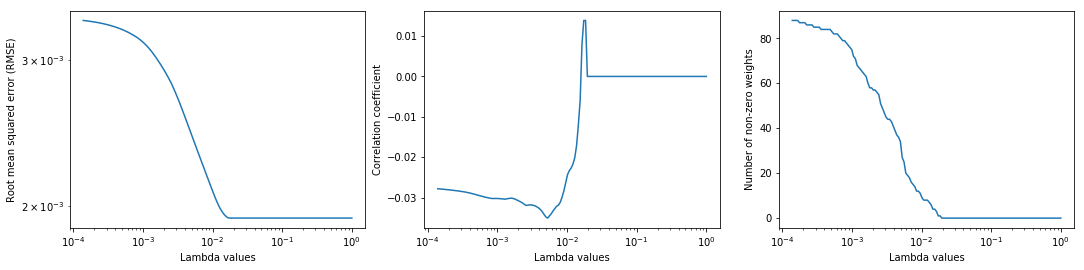

In [13]:
import pickle
import matplotlib
import matplotlib.pyplot as plt

with open("raw/encoder/lasso01_lam.raw", mode="br") as fbin:
    todo_lambda = pickle.load(fbin)

with open("raw/encoder/lasso01_err.raw", mode="br") as fbin:
    err_overlam = pickle.load(fbin)
    
with open("raw/encoder/lasso01_corr.raw", mode="br") as fbin:
    corr_overlam = pickle.load(fbin)
    
with open("raw/encoder/lasso01_spar.raw", mode="br") as fbin:
    spar_overlam = pickle.load(fbin)

myfig = plt.figure(figsize=(18,4))
ax_err = myfig.add_subplot(1, 3, 1)
plt.ylabel("Root mean squared error (RMSE)")
plt.xlabel("Lambda values")
ax_err.set_yscale('log')
ax_err.set_xscale('log')
ax_err.plot(todo_lambda, err_overlam)

ax_corr = myfig.add_subplot(1, 3, 2)
plt.ylabel("Correlation coefficient")
plt.xlabel("Lambda values")
ax_corr.set_xscale('log')
ax_corr.plot(todo_lambda, corr_overlam)

ax_spar = myfig.add_subplot(1, 3, 3)
plt.ylabel("Number of non-zero weights")
plt.xlabel("Lambda values")
ax_spar.set_xscale('log')
ax_spar.plot(todo_lambda, spar_overlam)

plt.show()

It is clear that such a simple toy example is wildly inefficient---the output is basically junk. Some serious modifications to the following factors will be required. Keep them in mind when reading the major tasks below.

- Setting of `w_init`.
- The size and range of the $\lambda$ grid.
- Number of iterations `t_max`.
- All of the filter bank parameters (in `myparas`), especially `freqs`, `dir`, `sdev`.
- The quantity and variety of filters used to generate features; both fine and coarse grids, and a wide variety of frequencies and orientations is likely necessary (see the "major tasks" below for more ideas).

<a id="tasks"></a>
## List of major tasks

0. Focus on "the early visual areas" looked at by Nishimoto et al. (V1, V2, V3, V3A, and V3B) in both hemispheres. Train a model for each voxel in these regions, and compute the performance (on test data) for the best lambda value (determined on the *training* set). Average the error/correlation over all the voxels in these regions.

0. By concatenating feature arrays, we can assemble features from a wide variety of filters. Indeed, this is almost certainly necessary for reasonable prediction quality. A wide variety of orientations and spatial frequencies was used in the cited neuroscience paper. Train several models (working as a team, perhaps) that use qualitatively *distinct* filter banks. Compare their respective performance, averaged across each of the early visual ROIs. Do you see any interesting trends? If so, what might these suggest about the "selectivity" of these regions of the brain?

0. Complete the above exercise for each subject. Is there much difference in performance between subjects? How does your best model perform against the cited work?

0. Another approach is to capture temporal delays in the feature vectors. For example, if our original feature vectors are $x_{i}$ for $i=1,\ldots,n$, then re-christen the feature vectors as $\widetilde{x}_{i} = (x_{i},x_{i-1})$ for a delay of *one* step (here, one second) for all $i>1$ (we lose one data point, now $n-1$ total). The dimension grows from $d$ to $2d$. Analogously, for a delay of $k$ steps, this would be $\widetilde{x}_{i} = (x_{i},x_{i-1},\ldots,x_{i-k})$ for all $i>k$, and lose $k$ data points for a total of $n-k$ now. Try several temporal delays; which seem to work best?

0. How does performance depend on ROI looked at? Which ROI saw comparatively good/bad performance? Provide visuals to highlight performance in each region.

0. Be sure to experiment with the learning algorithm parameters (number of iterations, size and range of $\lambda$ grid, etc.). What strategies did you find particularly effective? If you made any modifications to the algorithm, describe them.

0. (Bonus) Make a large data set of stimulus from any two subjects, and use the third subject's data as a evaluation of *inter-subject generalization* ability. How does performance compare with the more standard by-subject approach? Are there subjects that are particularly difficult to predict for? In contrast to this, considering the by-subject training approach we have considered thus far, how does our interpretation of *generalization* change?

## References:

 - Nishimoto, Shinji, et al. "Reconstructing visual experiences from brain activity evoked by natural movies." Current Biology 21.19 (2011): 1641-1646.
 - Description of dataset vim-2 (visual imaging 2), at CRCNS - Collaborative Research in Computational Neuroscience. https://crcns.org/data-sets/vc/vim-2/about-vim-2